In [25]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW, get_linear_schedule_with_warmup

In [3]:
# 1. データセットのクラス定義（惑星に関するテキスト）
class PlanetsDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for text in texts:
            encodings_dict = tokenizer('<|startoftext|>'+ text + '<|endoftext|>',
                                       truncation=True,
                                       max_length=max_length,
                                       padding="max_length")
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]


In [31]:
# 2. トークナイザーとモデルのロード
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [33]:
# ここで惑星に関するテキストデータをロード
planets =[
    "Mercury is the planet closest to the Sun in our solar system. It has extremely high temperatures, and its surface is covered with craters.",
    "Venus has a size and density similar to Earth, and due to the greenhouse effect, it has very high surface temperatures.",
    "Earth is the only planet that supports life, with abundant water and an atmosphere rich in oxygen.",
    "Mars is characterized by its red soil and there's a possibility that water existed there in the past.",
    "Jupiter is the largest planet in the solar system and has a strong magnetic field and many moons.",
    "Saturn is a gas giant known for its shining rings.",
    "Uranus is an ice giant with a blue-green color and has an extremely cold climate.",
    "Neptune is the outermost planet in the solar system and is a world with strong winds."
]

tokenizer.pad_token = tokenizer.eos_token

dataset = PlanetsDataset(planets, tokenizer, max_length=512)

In [35]:
from sklearn.model_selection import train_test_split


# データセットを訓練セットと検証セットに
train_texts, val_texts = train_test_split(planets, test_size=0.2, random_state=42)

# 訓練と検証のためのデータセットを作成する
train_dataset = PlanetsDataset(train_texts, tokenizer, max_length=512)
val_dataset = PlanetsDataset(val_texts, tokenizer, max_length=512)

# トレーニングと検証のためのDataLoadersの作成
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)


In [36]:
# 3. データローダーの設定
train_dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [37]:
# 4. トレーニングの設定
# GPUが使用可能か確認し、使用可能な場合はモデルをGPUに移動
device = "cuda" if torch.cuda.is_available() else "gpu"
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=-1)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/30 | Train Loss: 0.0797 | Val Loss: 0.0797
Epoch 2/30 | Train Loss: 0.0797 | Val Loss: 0.0797
Epoch 3/30 | Train Loss: 0.0797 | Val Loss: 0.0797
Early stopping triggered.


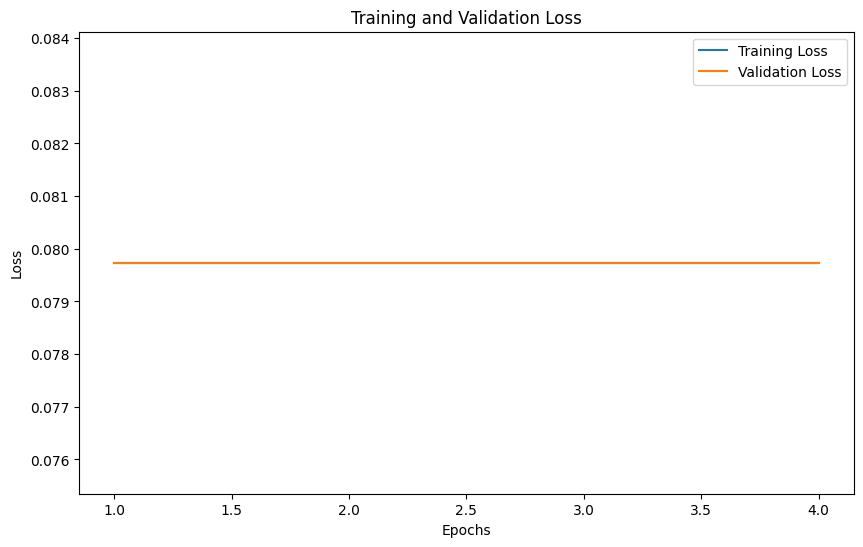

In [38]:
import matplotlib.pyplot as plt

epochs = 30
best_val_loss = float('inf')
patience = 0  # 改善が見られないエポック数を追跡
patience_limit = 3  # 早期停止のためのエポック数の限界

# エポックごとのトレーニングとバリデーション損失を保存するリスト
epoch_train_losses = []
epoch_val_losses = []

for epoch in range(epochs):
    # トレーニングフェーズ
    model.train()
    batch_train_losses = []  # バッチごとのトレーニング損失を格納するリスト
    for batch in train_dataloader:
        # トレーニングバッチの処理...
        batch_train_losses.append(loss.item())

    # バリデーションフェーズ
    model.eval()
    batch_val_losses = []  # バッチごとのバリデーション損失を格納するリスト
    for batch in val_dataloader:
        # バリデーションバッチの処理...
        batch_val_losses.append(loss.item())

    # 平均損失の計算
    avg_train_loss = sum(batch_train_losses) / len(batch_train_losses)
    avg_val_loss = sum(batch_val_losses) / len(batch_val_losses)

    # エポックごとの損失のリストに追加
    epoch_train_losses.append(avg_train_loss)
    epoch_val_losses.append(avg_val_loss)

    # 早期停止条件のチェック
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience = 0
    else:
        patience += 1

    if patience >= patience_limit:
        print("Early stopping triggered.")
        break

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# トレーニング完了後にグラフをプロット
epochs_range = range(1, epoch+2)  # early stoppingによりepochが途中で止まった場合に対応
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, epoch_train_losses, label='Training Loss')
plt.plot(epochs_range, epoch_val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [47]:
# tokenizerにパッドトークンを設定
tokenizer.pad_token = tokenizer.eos_token

# テキストのエンコード
input_text = "What is the Earth like?"
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)

# 入力テンソルをモデルと同じデバイスに移動
inputs = {k: v.to(device) for k, v in inputs.items()}

# テキスト生成の実行
output = model.generate(
    **inputs,
    max_length=100,
    temperature=0.7,
    top_k=50,
    top_p=0.9,
    no_repeat_ngram_size=2,
    num_return_sequences=1
)

# 出力のデコード
decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
print(decoded_output)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What is the Earth like?

The Earth is a flat, spherical, and elliptical planet. It is about 1.5 billion miles (2.6 billion kilometers) in diameter. The Earth's surface is composed of a dense, dense material called the mantle.
. Earth has a diameter of about 2.4 billion km (1.3 billion mi). The mantle is made up of three layers, each of which contains a layer of water. Water is heated by the sun,
